In [1]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, plot_confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.naive_bayes import GaussianNB

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset

In [2]:
from collections import Counter
import requests

with requests.get(
    "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

with requests.get(
    "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

In [3]:
df_features = pd.read_csv("features.csv")
df_target = pd.read_csv("target.csv")
df = df_features.merge(df_target, left_on='id', right_on='id')


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Selección de modelos

Buscamos el mejor valor del parámetro var_smoothing, en dos datasets distintos: preprocessing_arboles_2(df) y preprocessing_arboles_4(df), utilizando Randomized Search.

In [4]:
X_train1, X_test1, y_train1, y_test1 = preprocessing_arboles_2(df)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb1 = GaussianNB()

rgscv1 = RandomizedSearchCV(
    gnb1, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train1)

print(f"Best score: {rgscv1.best_score_}")
print(f"Best params {rgscv1.best_params_}")

Best score: 0.8346249717861577
Best params {'var_smoothing': 0.0767}


In [5]:
X_train2, X_test2, y_train2, y_test2 = preprocessing_arboles_4(df)

params = {
    'var_smoothing': np.arange(0.0001, 1, 0.0001)
}

gnb2 = GaussianNB()

rgscv2 = RandomizedSearchCV(
    gnb2, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train2)

print(f"Best score: {rgscv2.best_score_}")
print(f"Best params {rgscv2.best_params_}")

Best score: 0.8259010365487576
Best params {'var_smoothing': 0.1479}


# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_arboles_2(), con 'var_smoothing' = 0.0353.
Entrenamos el modelo y evaluamos utilizando el set de holdout.

In [15]:
X_train, X_test, y_train, y_test = preprocessing_arboles_2(df)

gnb = GaussianNB(var_smoothing=0.0767)
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
y_pred_proba = gnb.predict_proba(X_test)[:,1]

In [16]:
print(f"Auc Roc: {roc_auc_score(y_test, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Auc Roc: 0.8348440584900338
Accuracy: 0.8290160100737543
Precision: 0.6619718309859155
Recall: 0.4598450876477782
F1 Score: 0.5426990618234303


## Matriz de confusión

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


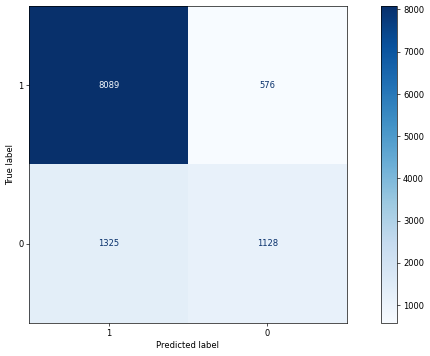

In [17]:
fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    gnb, X_test, y_test, cmap=plt.cm.Blues, display_labels=['1', '0'], ax=ax
)
plt.show()

## Curva ROC

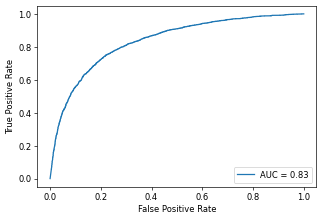

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales

In [24]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1mR_JNN0-ceiB5qV42Ff9hznz0HtWaoPF3B9zNGoNPY8/export?format=csv") as r, open("pred.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

df_pred = pd.read_csv("pred.csv")

df_pred_preprocess = preprocessing_nb_pred(df_pred)
y_pred_final = gnb.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

df_pred_final

,id,llovieron_hamburguesas_al_dia_siguiente
0,116706,no
1,58831,no
2,31981,no
3,2533,no
4,7270,si
...,...,...
29087,73456,no
29088,14471,no
29089,106482,no
29090,21057,si


In [25]:
df_pred_final.to_csv('predicciones/naive_bayes.csv', index=False)